In [1]:
# Import library
import pandas as pd
import glob,os,sys
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from scipy.cluster import hierarchy
import spacy
from nltk.tokenize import ToktokTokenizer
import re
import numpy as np
nlp=spacy.load("fr")
%matplotlib inline

## Data  import + data cleaning

 - tokenization
 - lemmatization 
 - stop words removal
 

In [4]:
df = pd.read_json("../data/crawling-results/ucl_test_2020.json")

In [6]:
#concatenate interesting text features
df["text"]=df.content.astype(str)+"\n"+df.goal.astype(str)+"\n"+df.prerequisite.astype(str)+"\n"+df.theme

In [7]:
df["text"]=df.content.astype(str)+"\n"+df.goal.astype(str)+"\n"+df.theme.astype(str)

In [18]:
def get_ngrams(lemmatized_text,n=3):
    ngrams = [" ".join(gr[x:x+i]) for gr in lemmatized_text for i in range(1,n+1) for x in range(0,len(gr),i)]
    return ngrams
    

In [20]:
remove=["«","»","/","\\"]

In [21]:
df["lemmas"]=df.text.apply(lambda x : [[w.lemma_ for w in s if not w.is_stop and w.pos_ != "PUNCT" and w.pos_ !="SPACE" and w.text not in remove] for s in nlp(x).sents])

In [22]:
df["ngrams"]=df.lemmas.apply(lambda x : get_ngrams(x))

In [28]:
odds={os.path.split(f)[-1].replace(".txt",""):open(f).read() for f in glob.glob("../data/ODD/*.txt")}

In [34]:
df_odd=pd.DataFrame.from_records(list(odds.items()),columns=["odd","text"])


In [35]:
df_odd["lemmas"]=df_odd.text.apply(lambda x : [[w.lemma_ for w in s if not w.is_stop and w.pos_ != "PUNCT" and w.pos_ !="SPACE" and w.text not in remove] for s in nlp(x).sents])

In [39]:
df_odd["ngrams"]=df_odd.lemmas.apply(lambda x:get_ngrams(x))
df_odd.ngrams[0]

['objectif',
 '13',
 'objectif 13',
 'objectif 13',
 'prendre',
 'urgence',
 'prendre urgence',
 'prendre urgence',
 'mesure',
 'lutter',
 'changement',
 'climatique',
 'répercussion',
 'changement',
 'climatique',
 'affecter',
 'pays',
 'continent',
 'mesure lutter',
 'changement climatique',
 'répercussion changement',
 'climatique affecter',
 'pays continent',
 'mesure lutter changement',
 'climatique répercussion changement',
 'climatique affecter pays',
 'continent',
 'perturbe',
 'économie',
 'national',
 'affecte',
 'vie',
 'coûte',
 'perturbe économie',
 'national affecte',
 'vie coûte',
 'perturbe économie national',
 'affecte vie coûte',
 'personne',
 'communautés',
 'pays',
 'demain',
 'personne communautés',
 'pays demain',
 'personne communautés pays',
 'demain',
 'condition',
 'météorologique',
 'changer',
 'niveau',
 'mer',
 'mont',
 'phénomène',
 'météorologique',
 'deviennent',
 'extrême',
 'émission',
 'gaz',
 'serre',
 'haut',
 'niveau',
 'histoire',
 'condition mété

In [40]:
df.to_json("../data/corpus_dataframe_ucl_preprocess.json")
df_odd.to_json("../data/odd_df_preprocess.json")

## exploration of Content
Explore courses content and compute some metrics with basic patterns + score tests
goal : 
 - validation of a vocabulary based approach
 - explore the disparity and sparsity of data
 - test some scoring intuitions with weighted terms
 

In [11]:
patterns={"[ée]colo\w*":1,"durab\w*":0.5,"climat\w*":1,"[ée]nerg\w*":1,"environ(ne)?m\w*":1,
          "carbon\w*":0.5,"d[ée]velop(pe)?ment":0.5, "biodiversité":1,
          "d[eé]velop(pe)?m\w* durab\w*":2,"changem\w* clim\w*":2,"sustain\w* develop\w*":2,
          "gestion\w* envir\w*":2,"transiti\w* [ée]nerg\w*":2, "stock\w* [eé]nerg\w*":2,
          "gestion\w* d[ée]chet\w*":2, "(bilan\w*|empreint\w*) carbon*":2, "[ée]nerg* (revouvelab\w*|vertes?)":2}
pattern_labels=[f'{p}_count' for p in patterns.keys()]


In [25]:
for p,label in zip(patterns.keys(),pattern_labels): 
    df[label]=df.bigrams.apply(lambda x:sum([(re.match(p,token) is not None) for token in x])*patterns[p])
    df[label]+=df.lemmas.apply(lambda x:sum([(re.match(p,token) is not None) for token in x])*patterns[p])
    
df["different_match"]=df[pattern_labels].apply(lambda x: (x!=0)).sum(axis=1)
df["total_count"]=df[pattern_labels].sum(axis=1)
df["score"]=df.total_count * df.different_match

In [26]:
df[pattern_labels+["different_match","total_count","score"]].iloc[1076]

[ée]colo\w*_count                           28.0
durab\w*_count                               1.0
climat\w*_count                              2.0
[ée]nerg\w*_count                            0.0
environ(ne)?m\w*_count                      14.0
carbon\w*_count                              1.0
d[ée]velop(pe)?ment_count                    1.0
biodiversité_count                           2.0
d[eé]velop(pe)?m\w* durab\w*_count           2.0
changem\w* clim\w*_count                     2.0
sustain\w* develop\w*_count                  0.0
gestion\w* envir\w*_count                    0.0
transiti\w* [ée]nerg\w*_count                0.0
stock\w* [eé]nerg\w*_count                   0.0
gestion\w* d[ée]chet\w*_count                0.0
(bilan\w*|empreint\w*) carbon*_count         0.0
[ée]nerg* (revouvelab\w*|vertes?)_count      0.0
different_match                              9.0
total_count                                 53.0
score                                      477.0
Name: 1076, dtype: f

In [27]:
df.sort_values(by=["score","total_count"],ascending=False)[["class","total_count","different_match","score"]][:20]

,class,total_count,different_match,score
761,Géopolitique des ressources naturelles,93.0,7,651.0
1076,Economie écologique et gestion de la transitio...,53.0,9,477.0
812,Stratégies publiques de mise en oeuvre de poli...,46.0,9,414.0
809,"Sociétés, populations, environnement, développ...",33.0,9,297.0
605,Développement durable et transition,32.0,6,192.0
1029,"Chaire André Molitor de réformes politiques, a...",23.0,8,184.0
788,Sociologie de l'environnement,34.0,5,170.0
767,Introduction to the physics of the climate sys...,42.0,4,168.0
684,Introduction à l'ingénierie de la biosphère,21.0,8,168.0
762,Introduction à l'ingénierie de la biosphère: p...,21.0,8,168.0


In [10]:
#for p in pattern_labels+["different_match","total_count"] : 
#    print(df.sort_values(by=p,ascending=False)[["class",p]][:2])

In [28]:
test_indices=[1076,810,761,664,3314,767,1502,510,3243,14,2,300]
df.iloc[test_indices,[0,-7,-6,-5,-4,-3,-2,-1]]


,class,stock\w* [eé]nerg\w*_count,gestion\w* d[ée]chet\w*_count,(bilan\w*|empreint\w*) carbon*_count,[ée]nerg* (revouvelab\w*|vertes?)_count,different_match,total_count,score
1076,Economie écologique et gestion de la transitio...,0,0,0,0,9,53.0,477.0
810,Séminaire en science et gestion de l'environne...,0,0,0,0,4,24.0,96.0
761,Géopolitique des ressources naturelles,0,0,0,0,7,93.0,651.0
664,Génie des procédés : Opérations unitaires,0,0,0,0,4,13.0,52.0
3314,Master's thesis,0,0,0,0,0,0.0,0.0
767,Introduction to the physics of the climate sys...,0,0,0,0,4,42.0,168.0
1502,Economie écologique,0,0,0,0,5,12.0,60.0
510,Chimie et chimie physique 1,0,0,0,0,2,28.0,56.0
3243,Biogéographie,0,0,0,0,4,31.0,124.0
14,Pathologie du sportif,0,0,0,0,0,0.0,0.0


In [21]:
df.sort_values("score",ascending=False)[["class","different_match","total_count","score"]].head(20)

,class,different_match,total_count,score
1076,Economie écologique et gestion de la transitio...,9,30.0,270.0
761,Géopolitique des ressources naturelles,7,38.0,266.0
812,Stratégies publiques de mise en oeuvre de poli...,9,23.5,211.5
809,"Sociétés, populations, environnement, développ...",9,23.0,207.0
1029,"Chaire André Molitor de réformes politiques, a...",8,18.5,148.0
1505,Introduction à l'ingénierie de la biosphère: A,8,17.0,136.0
762,Introduction à l'ingénierie de la biosphère: p...,8,17.0,136.0
684,Introduction à l'ingénierie de la biosphère,8,17.0,136.0
3222,Ecologie et société,6,21.0,126.0
605,Développement durable et transition,6,21.0,126.0


[ée]colo\w*_count          84
durab\w*_count             71
climat\w*_count            91
[ée]nerg\w*_count         171
environ(ne)?m\w*_count    398
dtype: int64


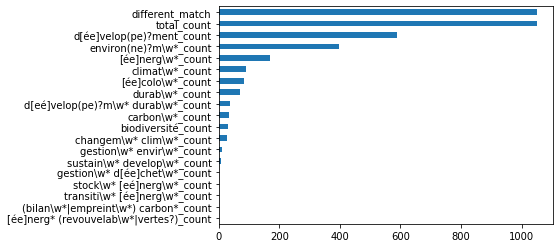

In [29]:
count_non_zeros=(df[pattern_labels+["total_count","different_match"]] > 0).sum()
print(count_non_zeros.head())
count_non_zeros.sort_values(ascending=True).plot(kind="barh")


In [15]:
df.loc[(df.score>0) & (df.score<4)][["class","total_count","different_match","score"]].sort_values(by="score",ascending=False)

,class,total_count,different_match,score
1020,Développement territorial et régional,3.5,1,3.5
2814,Neuropsychologie de l'enfant,3.5,1,3.5
304,Open Source strategy for software development,3.5,1,3.5
802,Chimie I,3.0,1,3.0
687,English : reading and listening comprehension ...,3.0,1,3.0
...,...,...,...,...
2376,Chaire Ryckmans : histoire et culture de l'Ara...,0.5,1,0.5
1293,Séminaire : économie sociale et transition,0.5,1,0.5
1294,Seminar International Economy : trade,0.5,1,0.5
628,"Architecture, ville et territoire : morphologies",0.5,1,0.5


In [17]:
#export scoring results
writer=pd.ExcelWriter("../data/scoring_test_word_count.xlsx")
key_list=["class"]+pattern_labels+["total_count","different_match","score"]
df[key_list].sort_values(by="score",ascending=False).to_excel(writer,index=None)
writer.close()

## Data Preprocessing
- word and ngrams count
- TfIdf Model


In [30]:
#WORD COUNT + most count
dictionary = Dictionary(df.bigrams.values.tolist())
bows = [dictionary.doc2bow(d) for d in df.bigrams.values.tolist()]
# Print the first five elements of the On the Origin of species' BoW model
for i in test_indices:
    df_count=pd.DataFrame(sorted([(dictionary.get(t[0]),t[1]) for t in bows[i]],
                                 key=lambda x: x[1],reverse=True),columns=["tokens","count"])
    print(df.iloc[i,0])
    print(df_count.head(),"\n")
    

Economie écologique et gestion de la transition - ULiège
                       tokens  count
0             économie social      5
1       transition écologique      4
2           écologique social      3
3  économique environnemental      3
4          economie ecologiqu      3 

Séminaire en science et gestion de l'environnement
                  tokens  count
0  développement durable      2
1            / formation      1
2                      1      1
3        UE développemer      1
4         accessible fin      1 

Géopolitique des ressources naturelles
                   tokens  count
0  géopolitique ressource     10
1   développement durable      8
2            partie cours      5
3       gestion ressource      4
4   changement climatique      4 

Génie des procédés : Opérations unitaires
                    tokens  count
0      opération unitairer      4
1                 partim b      4
2   séparation membranaire      4
3       opération unitaire      3
4  séparation purificat

In [19]:
# Generate the tf-idf model
model = TfidfModel(bows)
for i in test_indices[:3]:
    tf_doc=sorted(model[bows[i]],key=lambda x:x[1],reverse=True)
    tf_doc=pd.DataFrame([(dictionary.get(x[0]),x[1]) for x in tf_doc],columns=["tokens","score"])
    print(df.iloc[i,0])
    print(tf_doc.head(3))
    

Economie écologique et gestion de la transition - ULiège
                  tokens     score
0        économie social  0.192306
1  transition écologique  0.164285
2     interaction sphère  0.157817
Séminaire en science et gestion de l'environnement
                  tokens     score
0  développement durable  0.148001
1      Sud environnement  0.128496
2         actif approche  0.128496
Géopolitique des ressources naturelles
                   tokens     score
0  géopolitique ressource  0.376382
1   développement durable  0.173405
2             baser revue  0.150553


## TFIDF weighted score

In [20]:
def comput_tfidf_score(index,model,bows,dictionary):
    scores=[x[1] ** (1/patterns[p]) for x in model[bows[index]] 
            for p in patterns.keys() if re.match(p,dictionary.get(x[0])) is not None]
    
    return sum(scores)                           

In [21]:
df["tfidf_score"]=np.array([comput_tfidf_score(x,model,bows,dictionary) for x in range(df.shape[0])])
df.sort_values(by="tfidf_score",ascending=False)[["class","tfidf_score"]][:20]

,class,tfidf_score
3150,Paleoclimate dynamics and modelling,2.181584
812,Stratégies publiques de mise en oeuvre de poli...,1.654501
767,Introduction to the physics of the climate sys...,1.625838
809,"Sociétés, populations, environnement, développ...",1.619280
761,Géopolitique des ressources naturelles,1.600574
813,Méthodes d'évaluation et de gestion environnem...,1.495122
1076,Economie écologique et gestion de la transitio...,1.461708
788,Sociologie de l'environnement,1.412714
810,Séminaire en science et gestion de l'environne...,1.379074
784,Energies renouvelables,1.330542


In [22]:
#export scoring results
writer=pd.ExcelWriter("../data/scoring_test_tfidf.xlsx")
key_list=["class"]+pattern_labels+["total_count","different_match","tfidf_score"]
df[key_list].sort_values(by="tfidf_score",ascending=False).to_excel(writer,index=None)
writer.close()

In [23]:
tmp=df[["class","tfidf_score","score"]].copy()
tmp.loc[tmp.tfidf_score < 0.08].sort_values(by="tfidf_score",ascending=False).head()

,class,tfidf_score,score
568,Morphologie urbaine et analyse des paysages,0.079780,1.0
422,Projet d'architecture 2 : exploration,0.079770,1.0
531,"Architecture, ville et territoire : théories e...",0.079766,1.0
801,Chimie II,0.079752,4.0
1439,Stratégie d'entreprise,0.079712,4.0


In [24]:
def get_label(x):
    if x["score"] >4 and x["tfidf_score"] >= 0.1 : return "high"
    elif x["score"]==0 and x["tfidf_score"] == 0 :return "none"
    else: return "low"
    

In [25]:
df["category"]=[get_label(x) for i,x in df.iterrows()]


In [26]:
writer=pd.ExcelWriter("../data/comparison_df.xlsx")
df.to_excel(writer,index=None)
writer.close()

In [27]:
from sklearn.preprocessing import MinMaxScaler
normalizer=MinMaxScaler()
df["score_norm"]=normalizer.fit_transform(df["score"].values.reshape(-1,1))

In [28]:
df.sort_values(by="score_norm",ascending=False)[["class","score","score_norm"]][:5]

,class,score,score_norm
761,Géopolitique des ressources naturelles,409.5,1.000000
812,Stratégies publiques de mise en oeuvre de poli...,279.0,0.681319
1076,Economie écologique et gestion de la transitio...,256.5,0.626374
809,"Sociétés, populations, environnement, développ...",193.5,0.472527
1029,"Chaire André Molitor de réformes politiques, a...",116.0,0.283272


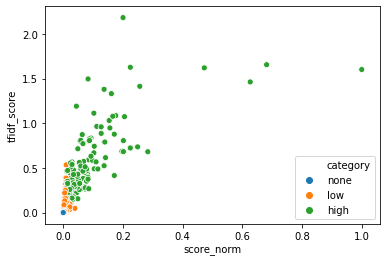

In [29]:
import seaborn as sns
sns.scatterplot(x="score_norm",y="tfidf_score",hue="category",data=df)

In [30]:
df.columns

Index(['class', 'shortname', 'anacs', 'location', 'teachers', 'language',
       'prerequisite', 'theme', 'goal', 'content', 'method', 'evaluation',
       'other', 'resources', 'biblio', 'faculty', 'text', 'lemmas', 'bigrams',
       '[ée]colo\w*_count', 'durab\w*_count', 'climat\w*_count',
       '[ée]nerg\w*_count', 'environ(ne)?m\w*_count', 'carbon\w*_count',
       'd[ée]velop(pe)?ment_count', 'biodiversité_count',
       'd[eé]velop(pe)?m\w* durab\w*_count', 'changem\w* clim\w*_count',
       'sustain\w* develop\w*_count', 'gestion\w* envir\w*_count',
       'transiti\w* [ée]nerg\w*_count', 'stock\w* [eé]nerg\w*_count',
       'gestion\w* d[ée]chet\w*_count', '(bilan\w*|empreint\w*) carbon*_count',
       '[ée]nerg* (revouvelab\w*|vertes?)_count', 'different_match',
       'total_count', 'score', 'tfidf_score', 'category', 'score_norm'],
      dtype='object')

In [32]:
import plotly.express as px


fig = px.scatter_3d(df, x="[ée]colo\w*_count", y="climat\w*_count", z="environ(ne)?m\w*_count",
                 hover_name="class",hover_data=["class","tfidf_score"])

fig.show()


## Similarity matrix with tfidf

In [33]:
# Load the library allowing similarity computations
from gensim import similarities

# Compute the similarity matrix (pairwise distance between all texts)
sims = similarities.MatrixSimilarity(model[bows])


In [34]:
# Transform the resulting list into a dataframe
sims_df = pd.DataFrame(list(sims),index=df["class"].values.tolist(),columns=df["class"].values.tolist())
print(df.iloc[test_indices[0],0],"\n")
print(sims_df.iloc[test_indices[0]].sort_values(ascending=False)[:10])

Economie écologique et gestion de la transition - ULiège 

Economie écologique et gestion de la transition - ULiège       0.999999
Economie sociale et transition écologique et sociale           0.319497
Economie écologique                                            0.249494
Economie sociale                                               0.093554
Ethique de l'économie sociale                                  0.083670
Innovation sociale et politiques publiques                     0.080124
Séminaire d'économie sociale                                   0.034680
Développement durable et transition                            0.031102
Gestion stratégique en économie sociale - ULiège               0.030611
Mutations culturelles contemporaines: approche sociologique    0.030240
Name: Economie écologique et gestion de la transition - ULiège, dtype: float64


## CLUSTERING

In [ ]:
# Import libraries
from scipy.cluster import hierarchy

# Compute the clusters from the similarity matrix,
# using the Ward variance minimization algorithm
Z = hierarchy.linkage(sims_df,method="ward")

# Display this result as a horizontal dendrogram
# a=hierarchy.dendrogram(Z)